# 머신러닝

### * 오류 메세지 관리

In [106]:
import warnings
warnings.filterwarnings(action='ignore')

### * import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
from imblearn.over_sampling import SMOTE
import seaborn as sns
from scipy.stats import chi2_contingency


## 1. 랜덤 포레스트

### 1-1.데이터셋 읽기


In [2]:
data = pd.read_csv('/Users/j/Desktop/AI camp/2차 프로젝트/SKN06-2nd-7Team/Data/HR_Employee.csv')
data.shape

(1470, 35)

In [3]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### 1-2. EDA
- 데이터셋의 특성을 파악하기 위해 EDA를 진행한다.
- EDA를 통해 데이터셋의 분포, 결측치, 이상치 등을 확인한다.
- 데이터셋의 특성을 파악한 후, 모델링을 진행하기 위한 전처리 방향을 설정한다.
- EDA는 전체 데이터셋을 대상으로 진행합니다.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [5]:
# 기본 통계 확인(수치형 데이터)
data.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


### 1-2-1. Target 분포 확인

----------개수----------
Attrition
No     1233
Yes     237
Name: count, dtype: int64
----------비율----------
Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64


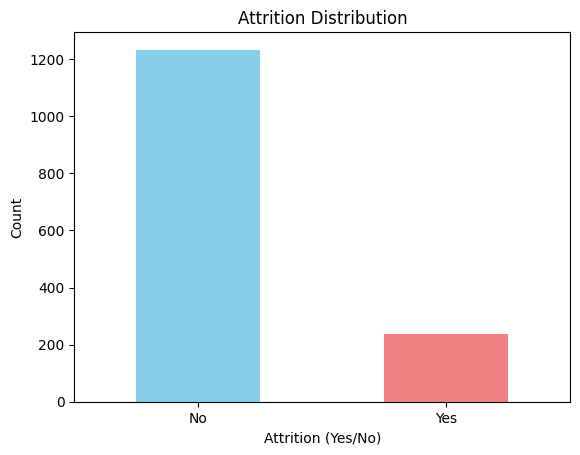

In [6]:
# attrition 분포 확인

print("----------개수----------")
print(data['Attrition'].value_counts())

print("----------비율----------")
print(data['Attrition'].value_counts(normalize=True))

# 시각화 - 막대그래프
import matplotlib.pyplot as plt

data['Attrition'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Attrition Distribution')
plt.xlabel('Attrition (Yes/No)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### 1-2-1. 이상치 및 결측치 확인

In [4]:
# class 불균형 해결 - oversampling

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# 범주형 변수 One-Hot Encoding
df = pd.get_dummies(data, drop_first=True)
X = df.drop("Attrition_Yes", axis=1)

y = df['Attrition_Yes']

# Label Encoding
le = LabelEncoder()
y = le.fit_transform(y)

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("After SMOTE Resampling:")
print(pd.Series(y_resampled).value_counts())

After SMOTE Resampling:
1    1233
0    1233
Name: count, dtype: int64


In [8]:
## 결측치 확인
data.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [51]:
# 이상치 확인

In [9]:
# IQR 기반으로 Outlier 값 조회 메소드

def is_outlier(data, whis=1.5):
    """
    IQR 기반으로 Outlier 값 조회 메소드
    parameter
        data: outlier를 찾을 데이터
        whis: IQR에 몇배를 극단치 계산에 사용할 지 비율. rate를 크게하면 outlier범위를 넓게 잡는다. 작게 주면 범위를 좁게 잡는다.
    return
        bool type ndarray: 각 원소별 outlier 여부 (True: Outlier(이상치), False: 정상범위값)
    """
    q1 = np.quantile(data, q=0.25)
    q3 = np.quantile(data, q=0.75)
    IQR = q3 - q1
    return (data < q1 - IQR * whis) | (data > q3 + IQR * whis)


def get_normal_range(data, whis=1.5):
    """
    IQR 기반으로 정상범위 조회 메소드
    parameter
        data: 조회할 대상 데이터
        whis: IQR에 몇배를 극단치 계산에 사용할 지 비율. rate를 크게하면 outlier범위를 넓게 잡는다. 작게 주면 범위를 좁게 잡는다.
    return
        tuple: (lower_bound, upper_bound) - 정상범위의 하한값과 상한값
    """
    q1 = np.nanquantile(data, q=0.25)
    q3 = np.nanquantile(data, q=0.75)
    IQR = q3 - q1
    lower_bound = q1 - IQR * whis
    upper_bound = q3 + IQR * whis
    return lower_bound, upper_bound

In [10]:
## 시각화 (number 타입만)
### 나눠서 그리기 위해 컬럼이름들 조회
c = data.select_dtypes(include=[np.number]).drop(columns=data.columns[0]).columns
len(c)

25

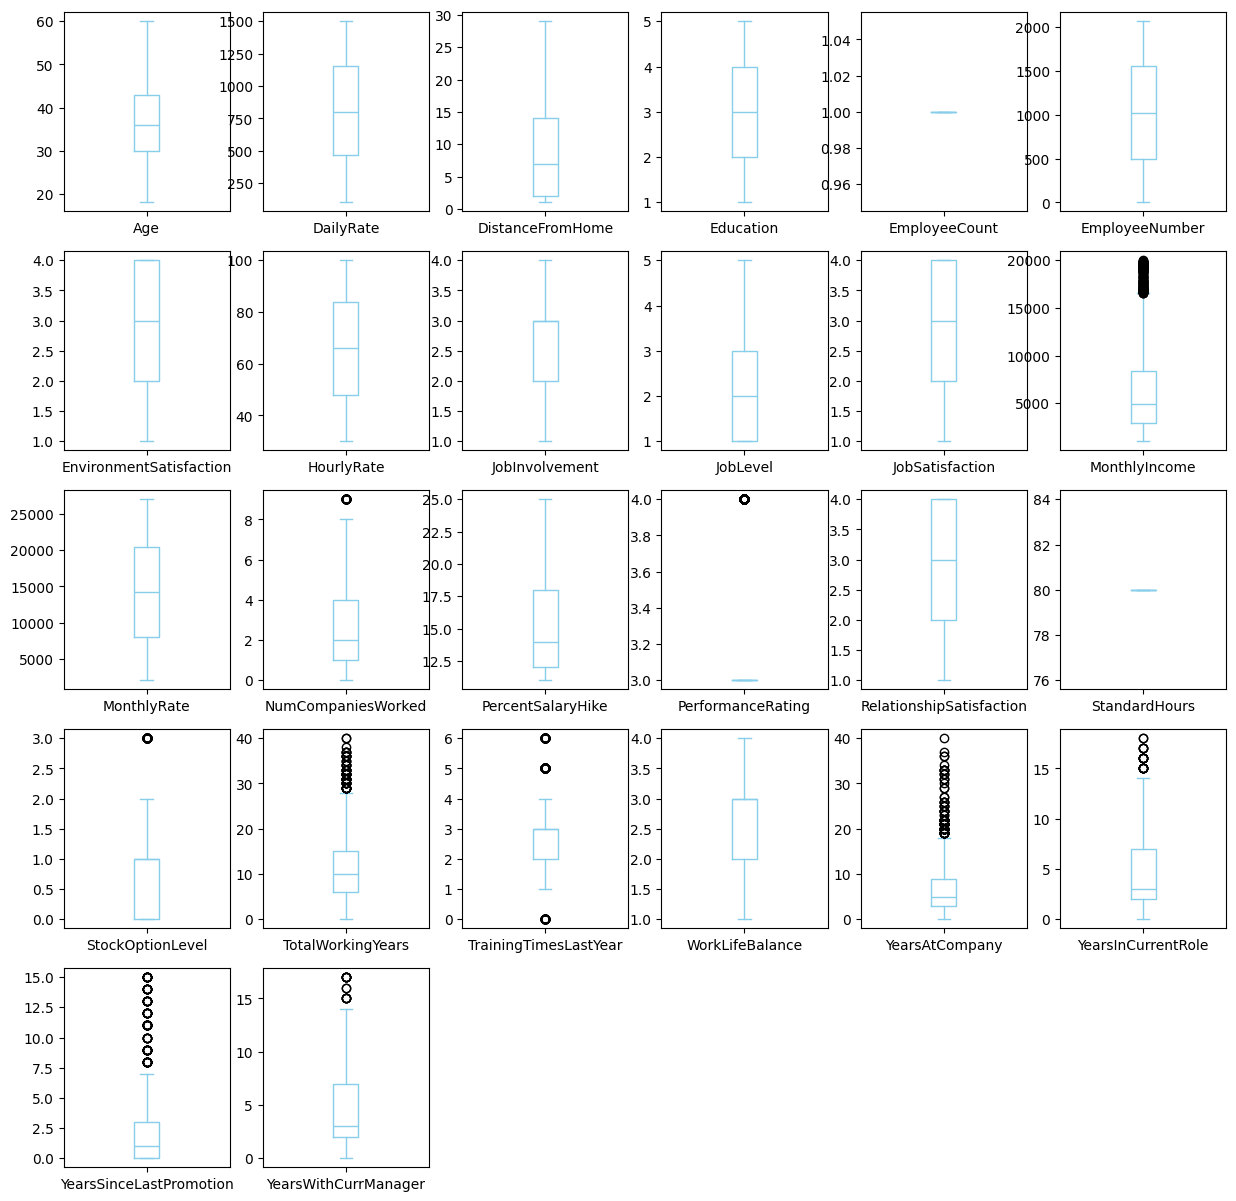

In [11]:
# subplots=True, layout=(3, 4): 3행 4열로 나눠서
data.select_dtypes(include=[np.number]).plot(
    kind='box', 
    subplots=True, 
    layout=(5, 6), 
    figsize=(15, 15), 
    color='skyblue');

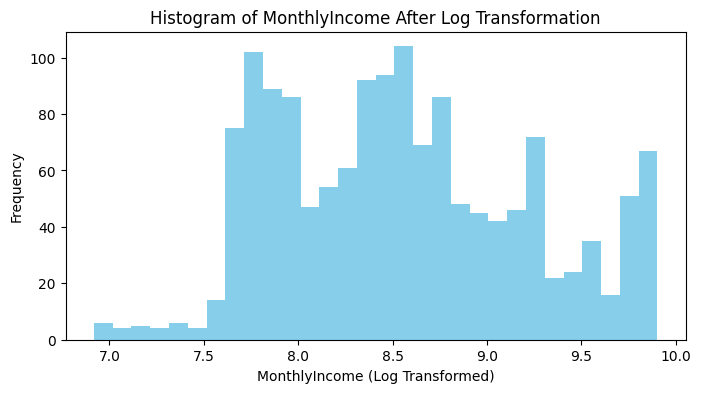

In [5]:
# 이상치 처리 - MonthlyIncome

import numpy as np
import matplotlib.pyplot as plt

data['MonthlyIncome_Log'] = np.log1p(data['MonthlyIncome'])

# 로그 변환 후의 분포 시각화
plt.figure(figsize=(8, 4))
plt.hist(data['MonthlyIncome_Log'], bins=30, color='skyblue')
plt.title('Histogram of MonthlyIncome After Log Transformation')
plt.xlabel('MonthlyIncome (Log Transformed)')
plt.ylabel('Frequency')
plt.show()

In [6]:
# 이상치 처리하여 변수명이 변경되었으므로 불필요한 변수 제거 
columns_to_drop = ['MonthlyIncome']
data_cleaned = data.drop(columns=columns_to_drop)

# 제거 후 dataframe 확인
print("Columns after removal:")
print(data_cleaned.columns)

Columns after removal:
Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'MonthlyIncome_Log'],
      dtype='object')


Data shape after removing outliers: (1092, 36)


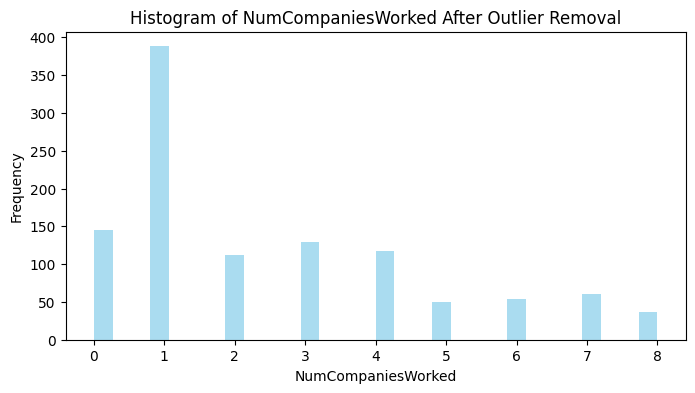

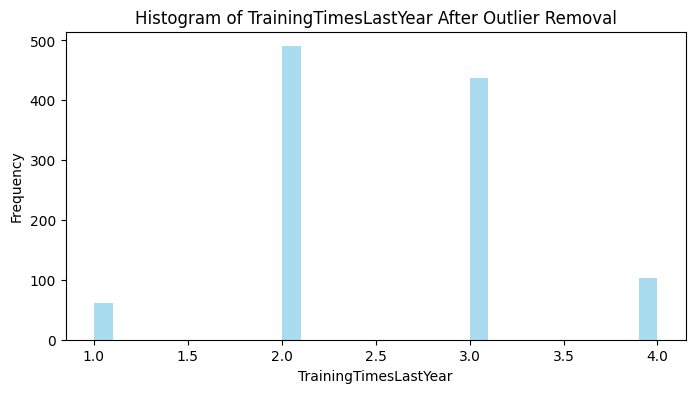

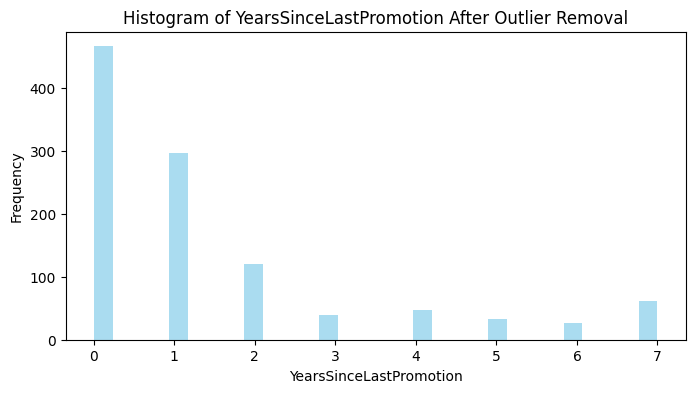

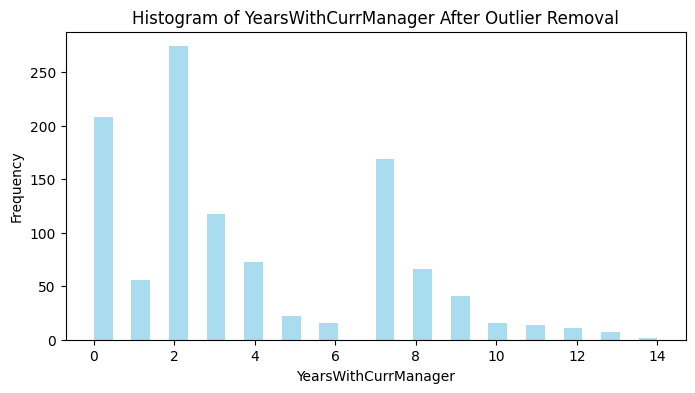

In [7]:
# 이상치 처리 - NumCompaniesWorked, TrainingTimesLastYear, YearsSinceLastPromotion, YearsWithCurrManager
variables_to_process = ['NumCompaniesWorked', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

for feature in variables_to_process:
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]

# 처리 후 데이터 크기 확인
print(f"Data shape after removing outliers: {data.shape}")

# 이상치 제거 후 변수들 시각화
import matplotlib.pyplot as plt

variables_to_process = ['NumCompaniesWorked', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

for feature in variables_to_process:
    plt.figure(figsize=(8, 4))
    plt.hist(data[feature], bins=30, color='skyblue', alpha=0.7)
    plt.title(f'Histogram of {feature} After Outlier Removal')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [8]:
# 불필요한 열 제거
data = data.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1092 entries, 1 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1092 non-null   int64  
 1   Attrition                 1092 non-null   object 
 2   BusinessTravel            1092 non-null   object 
 3   DailyRate                 1092 non-null   int64  
 4   Department                1092 non-null   object 
 5   DistanceFromHome          1092 non-null   int64  
 6   Education                 1092 non-null   int64  
 7   EducationField            1092 non-null   object 
 8   EmployeeNumber            1092 non-null   int64  
 9   EnvironmentSatisfaction   1092 non-null   int64  
 10  Gender                    1092 non-null   object 
 11  HourlyRate                1092 non-null   int64  
 12  JobInvolvement            1092 non-null   int64  
 13  JobLevel                  1092 non-null   int64  
 14  JobRole      

### 1-3. 데이터셋 준비

In [9]:
# 수치형/범주형 변수 구분
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

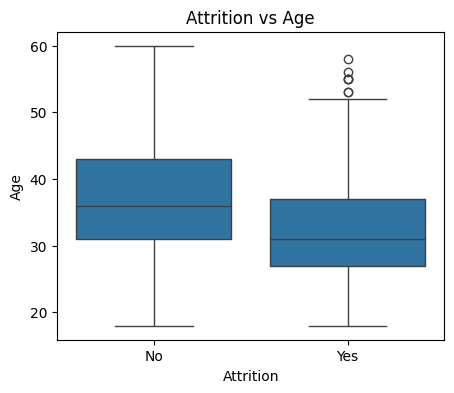

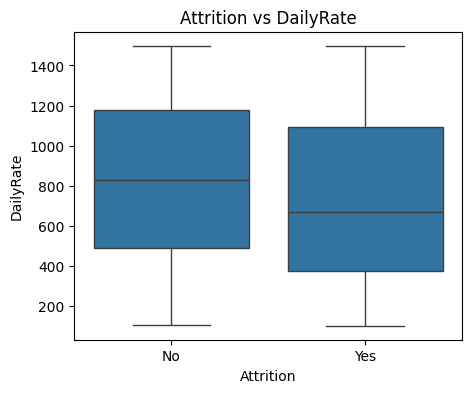

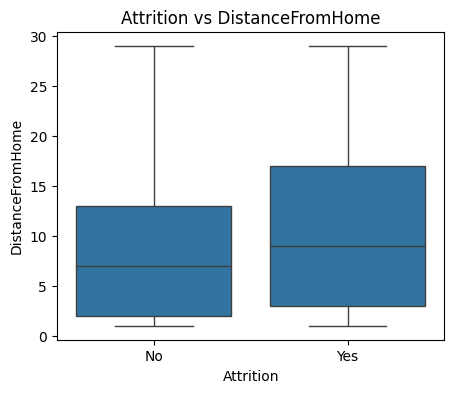

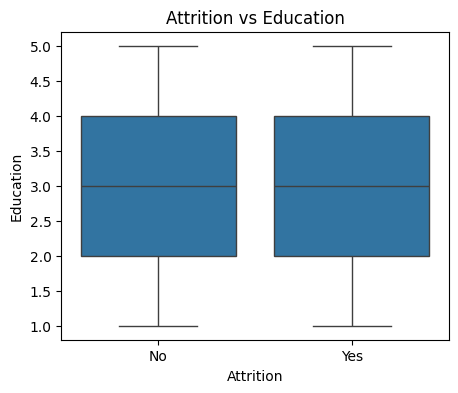

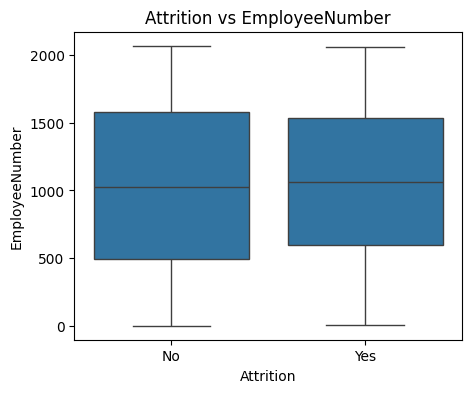

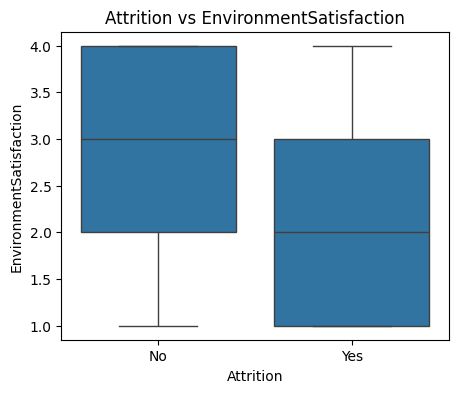

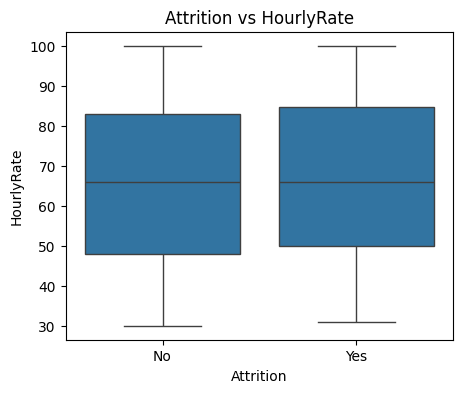

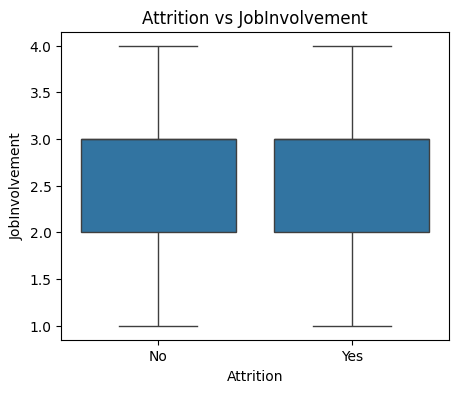

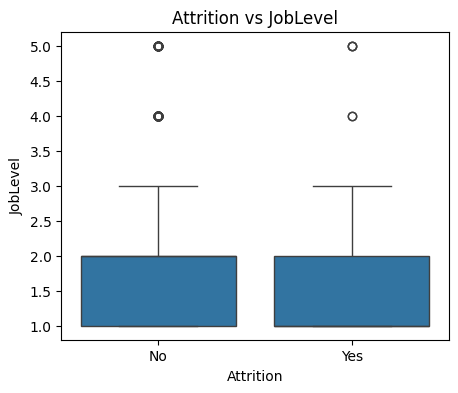

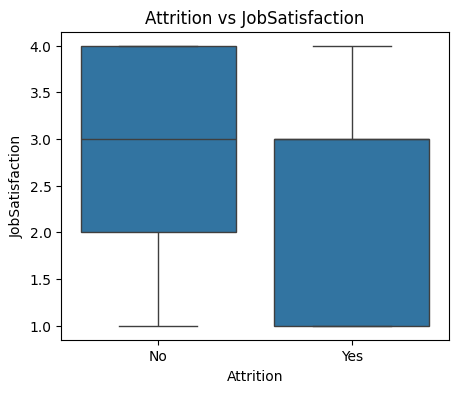

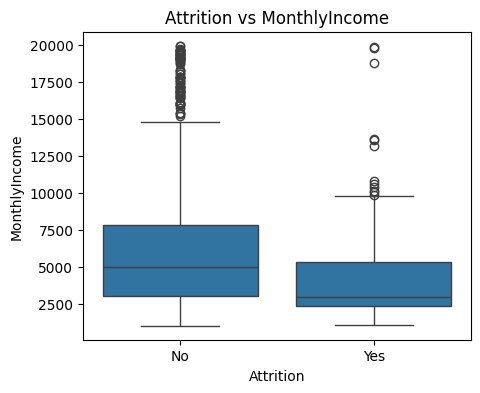

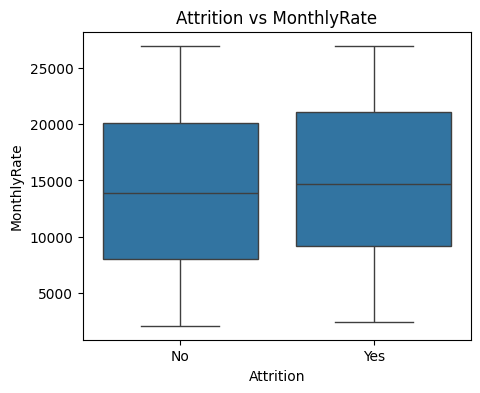

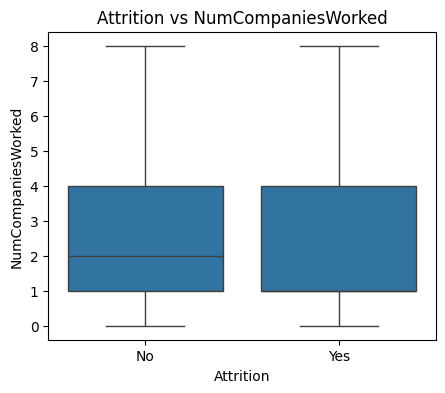

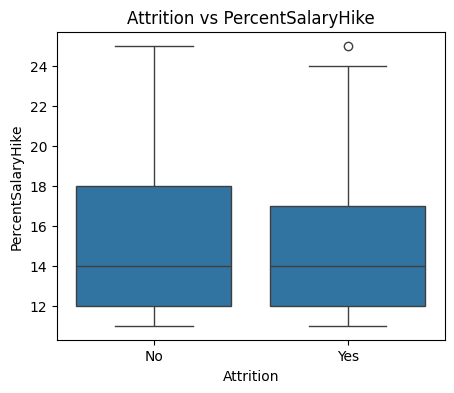

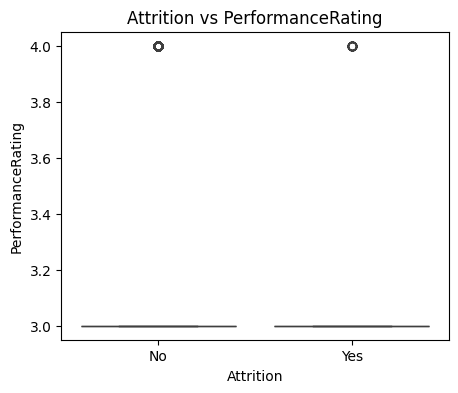

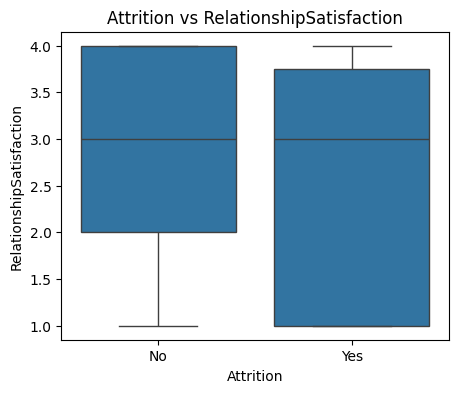

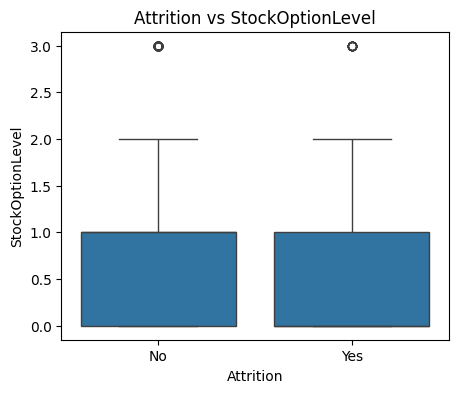

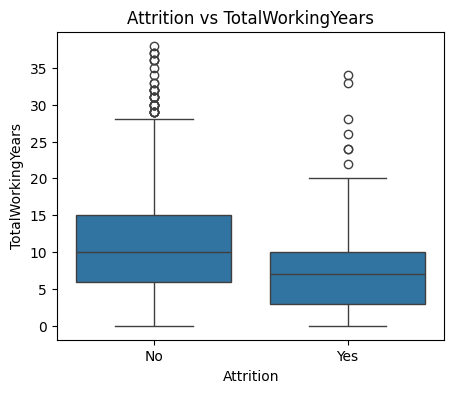

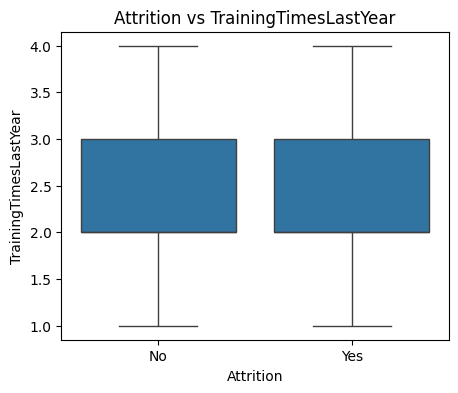

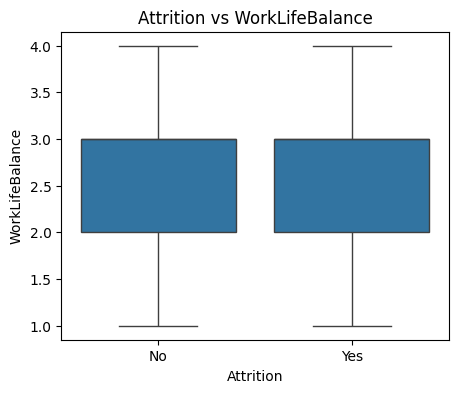

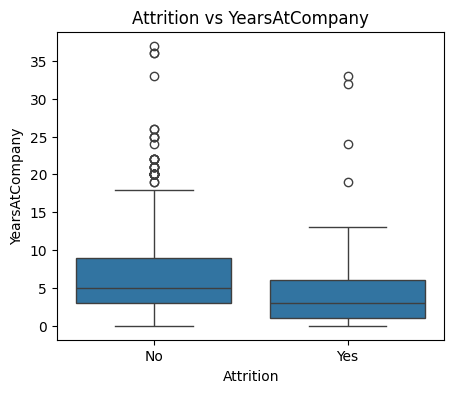

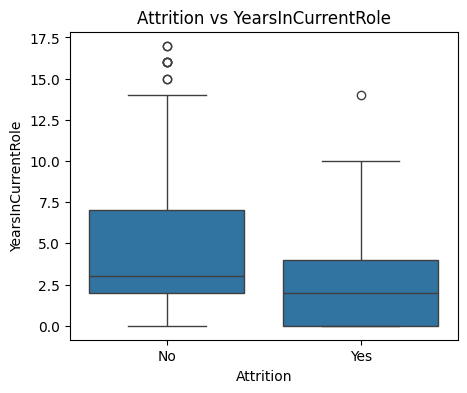

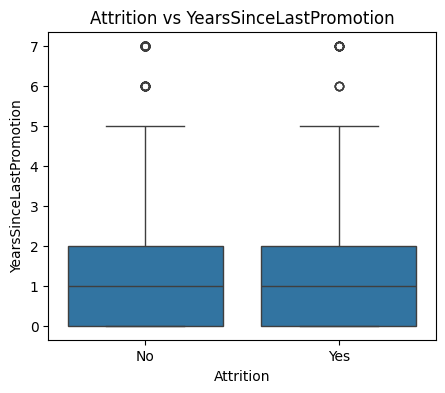

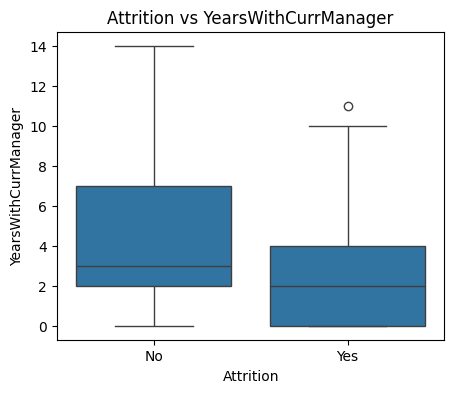

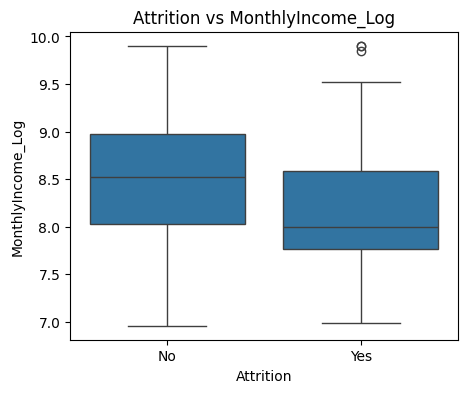

In [10]:
# 수치형 변수와 attrition 간의 관계 분석
for feature in numerical_features:
    plt.figure(figsize=(5, 4))
    sns.boxplot(x='Attrition', y=feature, data=data)
    plt.title(f'Attrition vs {feature}')
    plt.show()

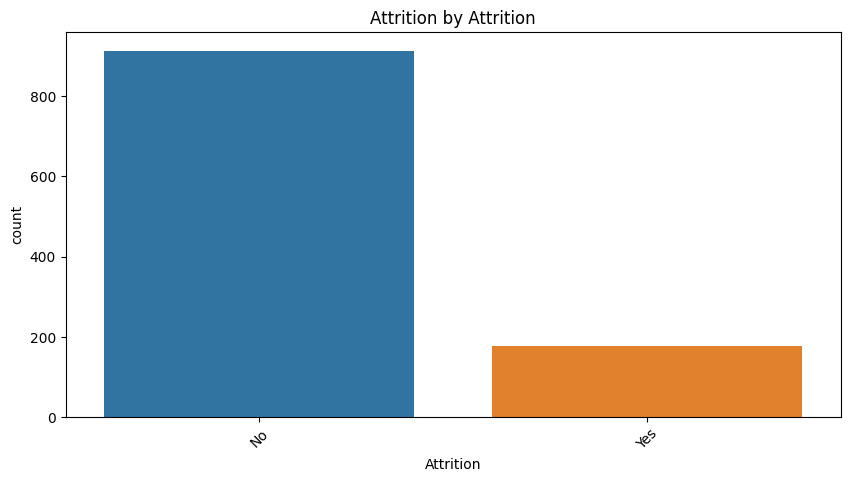

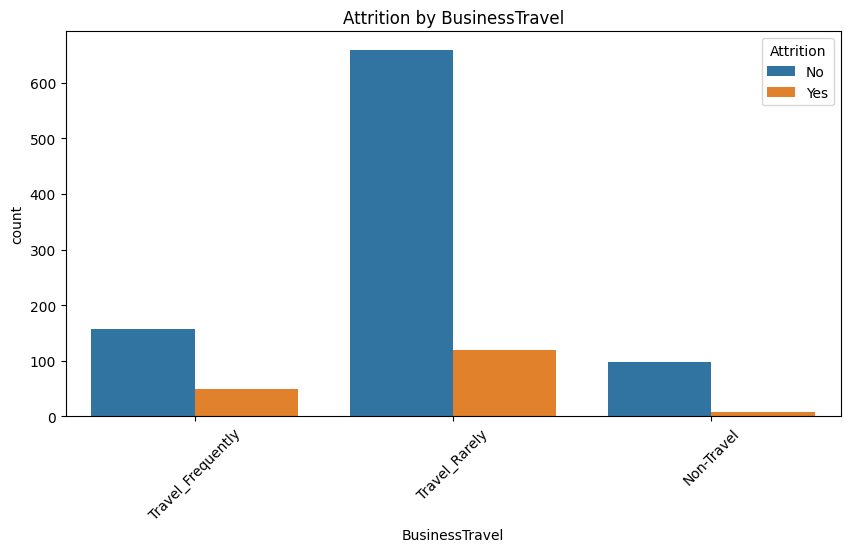

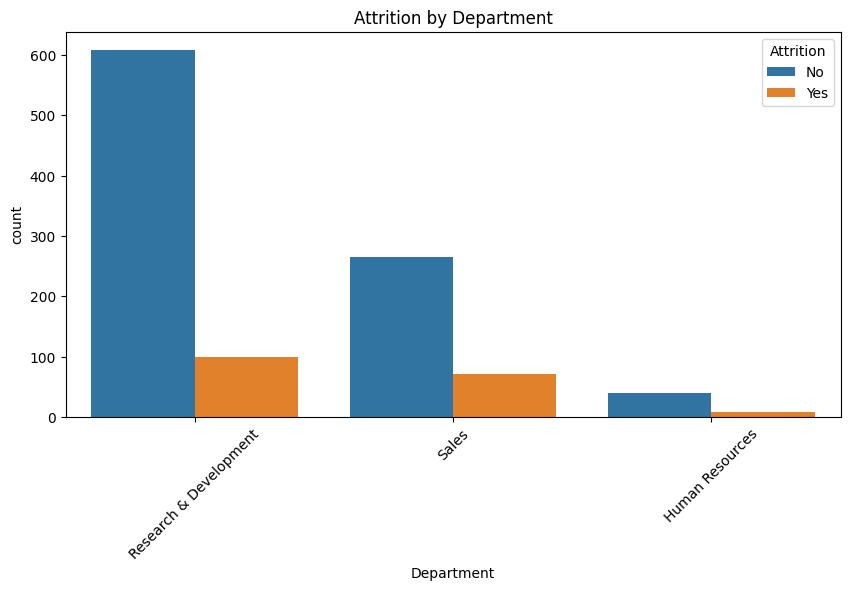

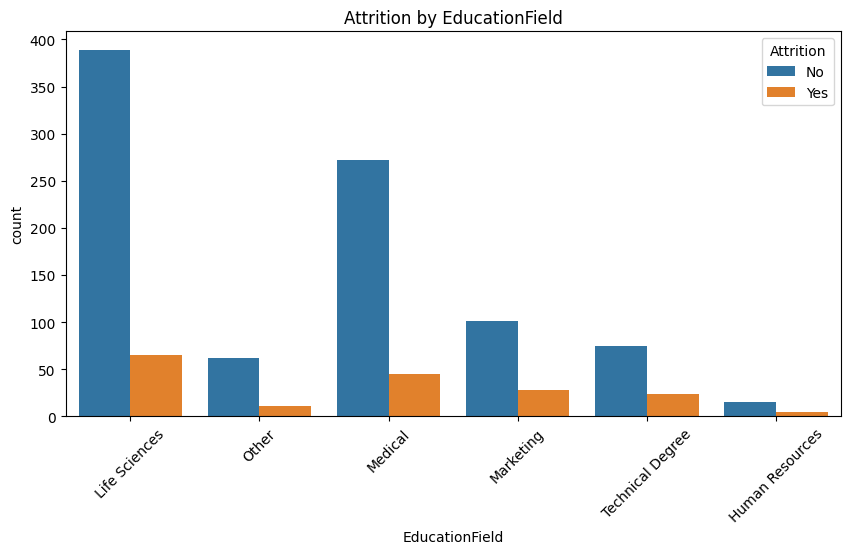

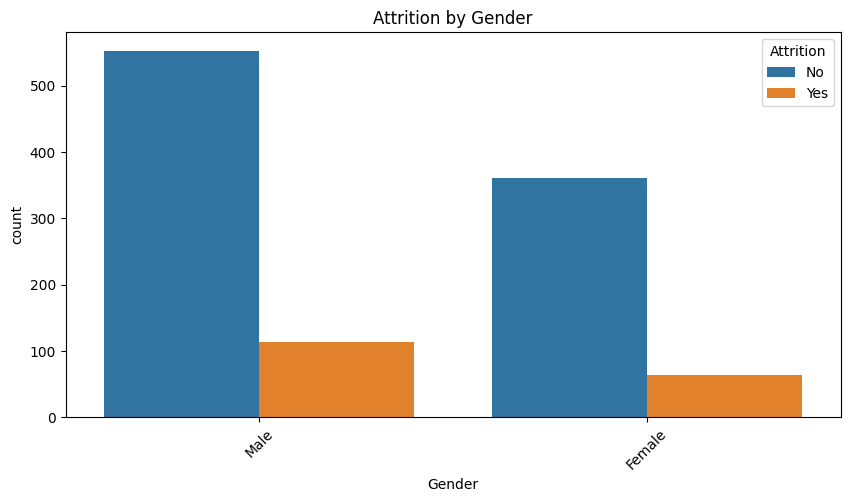

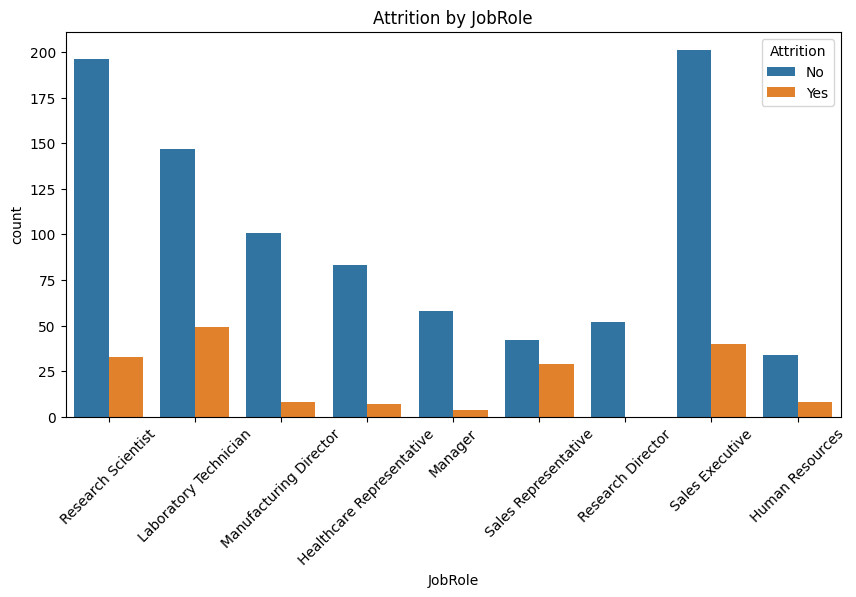

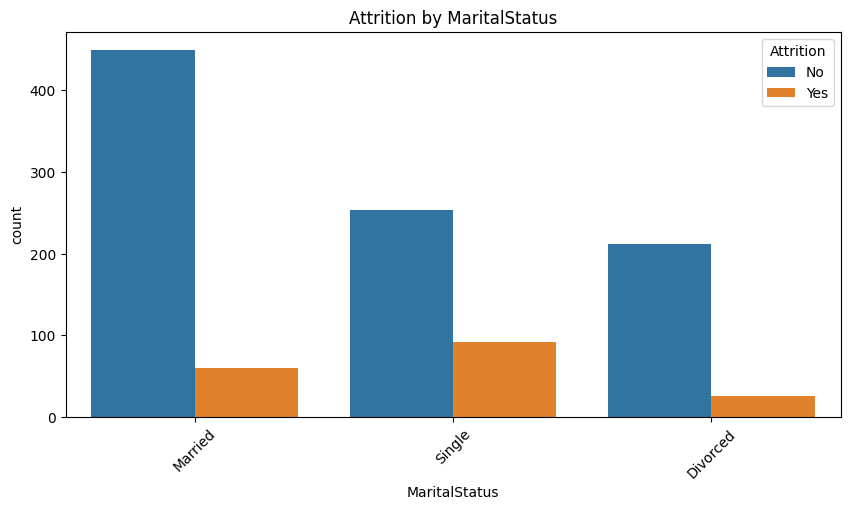

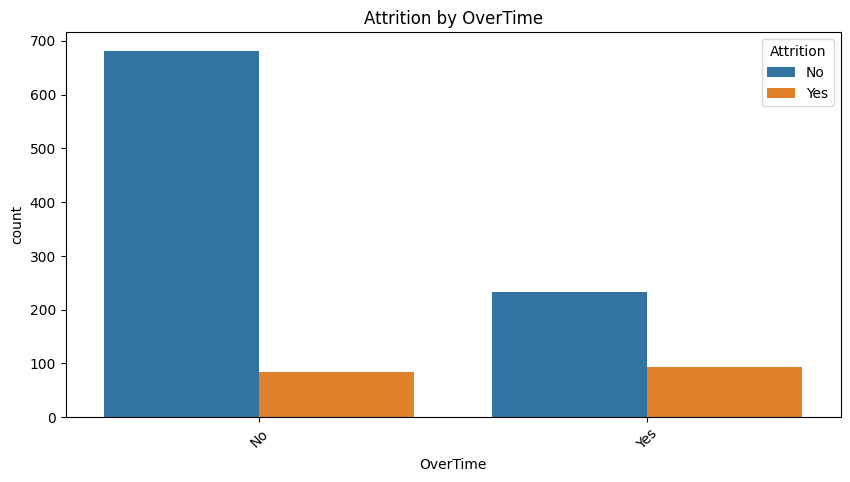

In [18]:
# 범주형 변수와 attrition 간의 관계 분석
for feature in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=feature, hue='Attrition', data=data)
    plt.title(f'Attrition by {feature}')
    plt.xticks(rotation=45)
    plt.show()

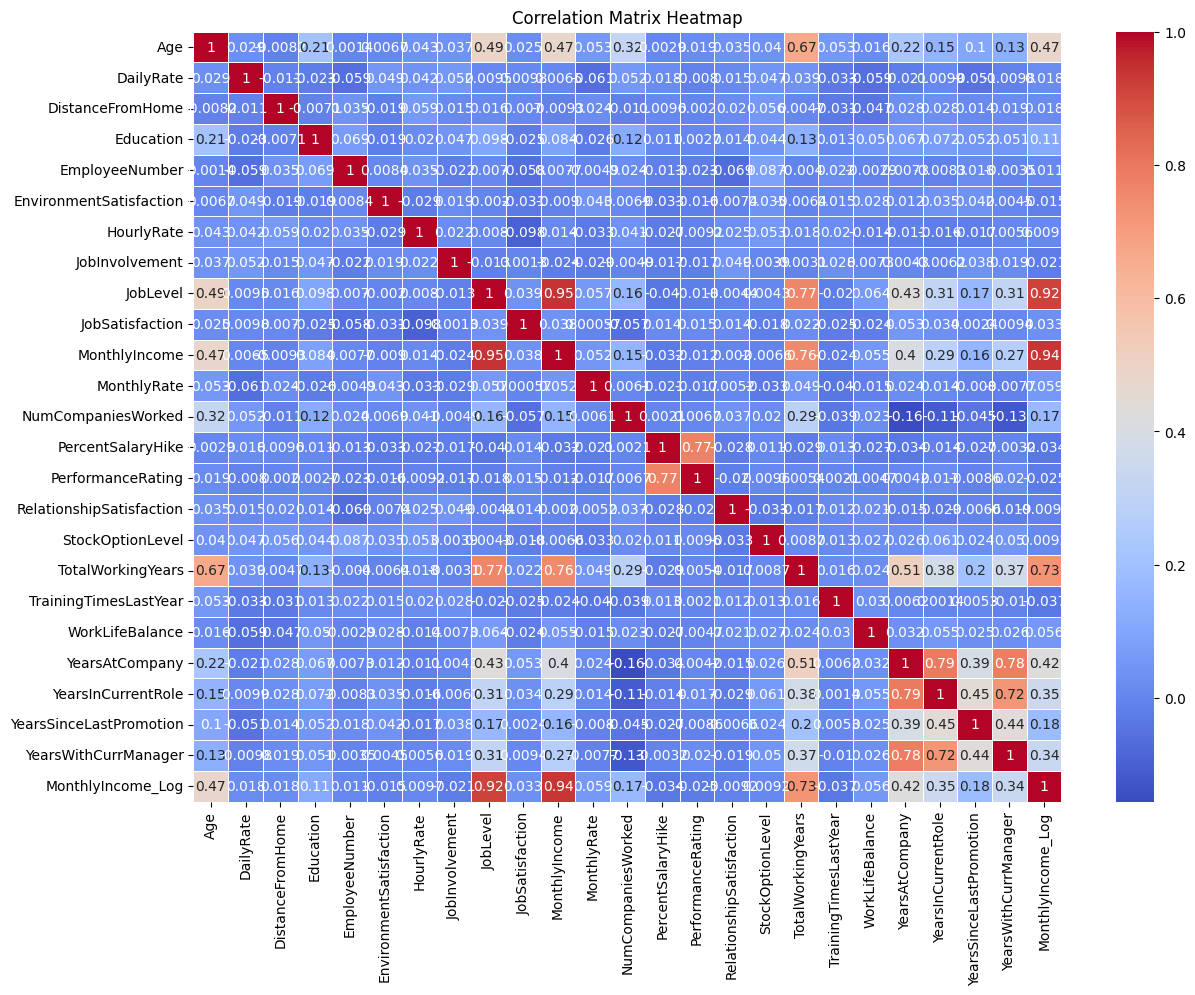

In [19]:
# 수치형 변수들의 상관관계 분석
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [11]:
# 범주형 변수와 attrition 간의 카이제곱 검정
for feature in categorical_features:
    contingency_table = pd.crosstab(data[feature], data['Attrition'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'Chi-square Test for {feature}')
    print(f'Chi-square Statistic: {chi2}, p-value: {p}\n')

Chi-square Test for Attrition
Chi-square Statistic: 1084.6827193426273, p-value: 7.047408044797095e-238

Chi-square Test for BusinessTravel
Chi-square Statistic: 15.3872804505782, p-value: 0.00045571623888784207

Chi-square Test for Department
Chi-square Statistic: 8.355272847239974, p-value: 0.015334709524051804

Chi-square Test for EducationField
Chi-square Statistic: 10.86803305387239, p-value: 0.05406019811104867

Chi-square Test for Gender
Chi-square Statistic: 0.6441942466861782, p-value: 0.4221960680922928

Chi-square Test for JobRole
Chi-square Statistic: 68.81270115971287, p-value: 8.465675784544105e-12

Chi-square Test for MaritalStatus
Chi-square Statistic: 39.81214471009264, p-value: 2.26413657212901e-09

Chi-square Test for OverTime
Chi-square Statistic: 52.21256215627322, p-value: 4.980649332578717e-13



In [21]:
# 제거할 불필요한 변수
## columns_to_drop = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours', 'MonthlyIncome']

# 해당 변수 제거
## data_cleaned = data.drop(columns=columns_to_drop)

# 제거 후 데이터프레임 확인
## print("Columns after removal:")
## print(data_cleaned.columns)

In [12]:
# Feature Engineering

# YearsWithOtherCompanies: 다른 회사에서 근무한 연수
# TotalWorkingYears + YearsAtCompany
data_cleaned['YearsWithOtherCompanies'] = data_cleaned['TotalWorkingYears'] - data_cleaned['YearsAtCompany']
data_cleaned['YearsWithOtherCompanies'] = data_cleaned['YearsWithOtherCompanies'].apply(lambda x: max(x, 0))  # 음수 값은 0으로 처리

# AgeAtJoining: 입사 당시 나이
## Age + YearsAtCompany
data_cleaned['AgeAtJoining'] = data_cleaned['Age'] - data_cleaned['YearsAtCompany']
data_cleaned['AgeAtJoining'] = data_cleaned['AgeAtJoining'].apply(lambda x: max(x, 0))  # 음수 값은 0으로 처리

# IncomePerYearWorked: 연차당 소득
## MonthlyIncome_Log + TotalWorkingYears
data_cleaned['IncomePerYearWorked'] = data_cleaned['MonthlyIncome_Log'] / (data_cleaned['TotalWorkingYears'] + 1)  # +1을 더해 0으로 나누는 것을 방지

# 새로운 특성 확인
print("Columns after feature engineering:")
print(data_cleaned.columns)

Columns after feature engineering:
Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'MonthlyIncome_Log', 'YearsWithOtherCompanies',
       'AgeAtJoining', 'IncomePerYearWorked'],
      dtype='object')


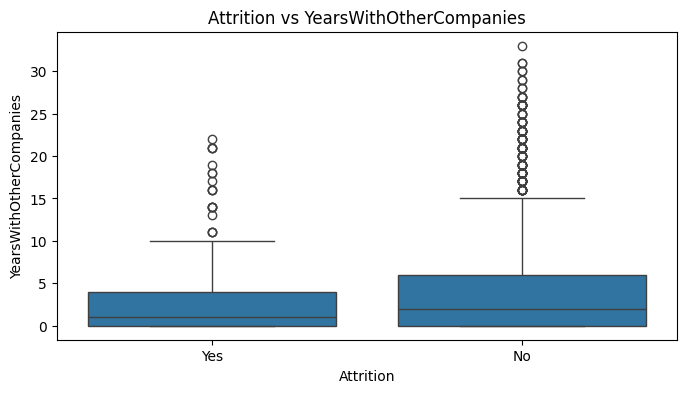

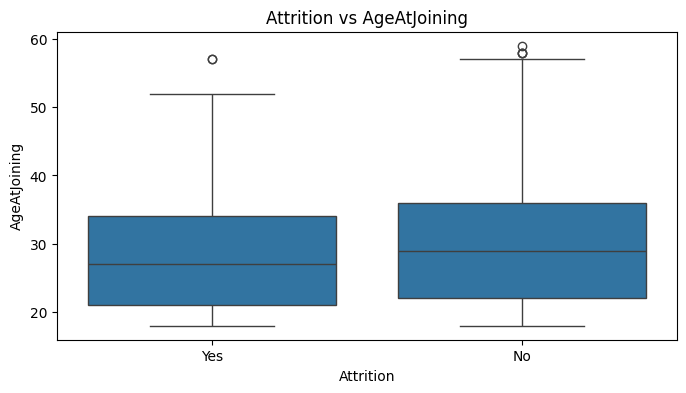

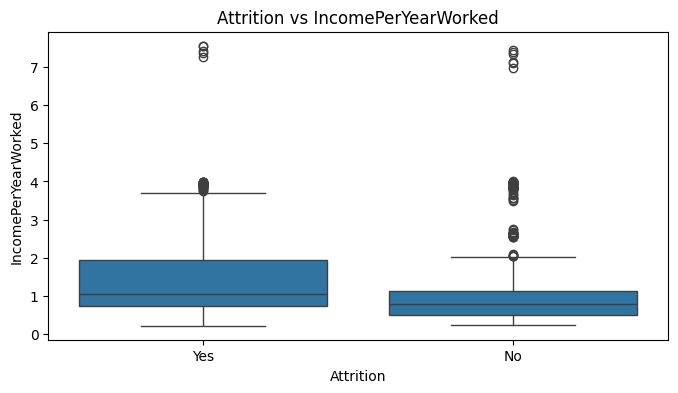

In [13]:
# 새로운 features 시각화

import matplotlib.pyplot as plt
import seaborn as sns

# YearsWithOtherCompanies vs Attrition
plt.figure(figsize=(8, 4))
sns.boxplot(x='Attrition', y='YearsWithOtherCompanies', data=data_cleaned)
plt.title('Attrition vs YearsWithOtherCompanies')
plt.show()

# AgeAtJoining vs Attrition
plt.figure(figsize=(8, 4))
sns.boxplot(x='Attrition', y='AgeAtJoining', data=data_cleaned)
plt.title('Attrition vs AgeAtJoining')
plt.show()

# IncomePerYearWorked vs Attrition
plt.figure(figsize=(8, 4))
sns.boxplot(x='Attrition', y='IncomePerYearWorked', data=data_cleaned)
plt.title('Attrition vs IncomePerYearWorked')
plt.show()

In [14]:
# 새로운 features들에 대한 이상치 제거 - IQR

new_features = ['YearsWithOtherCompanies', 'AgeAtJoining', 'IncomePerYearWorked']

for feature in new_features:
    q1 = data_cleaned[feature].quantile(0.25)
    q3 = data_cleaned[feature].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    data_cleaned = data_cleaned[(data_cleaned[feature] >= lower_bound) & (data_cleaned[feature] <= upper_bound)]

# 이상치 제거 후 데이터 크기 확인
print(f"Data shape after removing outliers: {data_cleaned.shape}")

Data shape after removing outliers: (1158, 38)


In [15]:
# 수치형 변수 Scaling - 표준화
from sklearn.preprocessing import StandardScaler

numerical_features = data_cleaned.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
data_cleaned[numerical_features] = scaler.fit_transform(data_cleaned[numerical_features])

# 스케일링 후 데이터 확인
print("Data after scaling:")
print(data_cleaned[numerical_features].head())

Data after scaling:
        Age  DailyRate  DistanceFromHome  Education  EmployeeCount  \
0  0.647161   0.757405         -1.017088  -0.899322            0.0   
1  1.694559  -1.288925         -0.149427  -1.873517            0.0   
2  0.123463   1.431227         -0.893136  -0.899322            0.0   
3 -0.400236   1.478469         -0.769185   1.049068            0.0   
4 -1.185784  -0.513160         -0.893136  -1.873517            0.0   

   EmployeeNumber  EnvironmentSatisfaction  HourlyRate  JobInvolvement  \
0       -1.711981                -0.645529    1.400494        0.357094   
1       -1.710326                 0.276200   -0.223936       -1.049419   
2       -1.707017                 1.197929    1.302044       -1.049419   
3       -1.705362                 1.197929   -0.470062        0.357094   
4       -1.702052                -1.567257   -1.257665        0.357094   

   JobLevel  ...  TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
0 -0.004354  ...              -2.21142

In [16]:
data_cleaned.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'MonthlyIncome_Log', 'YearsWithOtherCompanies',
       'AgeAtJoining', 'IncomePerYearWorked'],
      dtype='object')

In [17]:
# 데이터 분할
X = data_cleaned.drop(columns=['Attrition'])
y = data_cleaned['Attrition']

# train set 70%, test set 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 분할 후 크기 확인
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 810 samples
Test set size: 348 samples


In [18]:
# Feature Selection - 상관계수 기반(수치형 data), 카이제곱 검정 기반(범주형 data)
# 수치형 변수 상관계수 기반 제거
numerical_features = data_cleaned.select_dtypes(include=['int64', 'float64']).columns
data_numerical = data_cleaned[numerical_features]

corr_matrix = data_numerical.corr()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

print("Highly correlated pairs:")
print(high_corr_pairs)

## 상관계수가 높은 변수 중 하나 제거 (두 번째 변수를 제거)
columns_to_drop = []
for pair in high_corr_pairs:
    columns_to_drop.append(pair[1])

## 중복 제거 및 최종 제거할 수치형 변수 목록 생성
columns_to_drop = list(set(columns_to_drop))

# 카이제곱 검정 기반 범주형 변수 제거
categorical_features = data_cleaned.select_dtypes(include=['object']).columns
categorical_features = categorical_features.drop('Attrition') 

le = LabelEncoder()
y_encoded = le.fit_transform(data_cleaned['Attrition'])

from scipy.stats import chi2_contingency

chi2_insignificant_vars = []

for feature in categorical_features:
    contingency_table = pd.crosstab(data_cleaned[feature], y_encoded)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p > 0.05:
        chi2_insignificant_vars.append(feature)

print("Insignificant categorical variables based on chi-square test:")
print(chi2_insignificant_vars)

## 최종 제거할 변수 목록에 추가 
columns_to_drop.extend(chi2_insignificant_vars)
columns_to_drop = list(set(columns_to_drop))  # 중복 제거

# 최종 변수 제거
X_selected = data_cleaned.drop(columns=columns_to_drop).drop(columns=['Attrition'])  # 타겟 변수는 제외

print("Selected features for modeling:")
print(X_selected.columns)

Highly correlated pairs:
[('MonthlyIncome_Log', 'JobLevel')]
Insignificant categorical variables based on chi-square test:
['EducationField', 'Gender', 'Over18']
Selected features for modeling:
Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EmployeeCount', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'MonthlyIncome_Log', 'YearsWithOtherCompanies',
       'AgeAtJoining', 'IncomePerYearWorked'],
      dtype='object')


### 1-4. 모델 학습

In [24]:
target = data_cleaned['Attrition']
data_features = data_cleaned.drop(columns=['Attrition'])

#  범주형 변수 변환 - One-Hot Encoding
data_encoded = pd.get_dummies(data_cleaned, drop_first=True)

# 타겟 변수 인코딩 (No -> 0, Yes -> 1)
le = LabelEncoder()
target_encoded = le.fit_transform(target)

# 인코딩된 데이터에 타겟 변수 추가
data_encoded['Attrition'] = target_encoded

# 변수 분리 (타겟/특성)
X = data_encoded.drop(columns=['Attrition'])
y = data_encoded['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [20]:
# RandomForest 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 1-5. 모델 예측 및 평가

In [21]:
# 예측
y_pred = rf_model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       299
           1       1.00      1.00      1.00        49

    accuracy                           1.00       348
   macro avg       1.00      1.00      1.00       348
weighted avg       1.00      1.00      1.00       348



### 1-5. 특성 중요도 확인

In [22]:
# 특성 중요도 확인
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)
print("\nTop 10 Important Features:")
print(feature_importance)


Top 10 Important Features:
                feature  importance
29        Attrition_Yes    0.548834
50         OverTime_Yes    0.030049
25    MonthlyIncome_Log    0.026783
28  IncomePerYearWorked    0.025787
1             DailyRate    0.021722
0                   Age    0.021101
5        EmployeeNumber    0.018506
18    TotalWorkingYears    0.016219
12   NumCompaniesWorked    0.016004
2      DistanceFromHome    0.015722


### 1-5. 특성 중요도 시각화

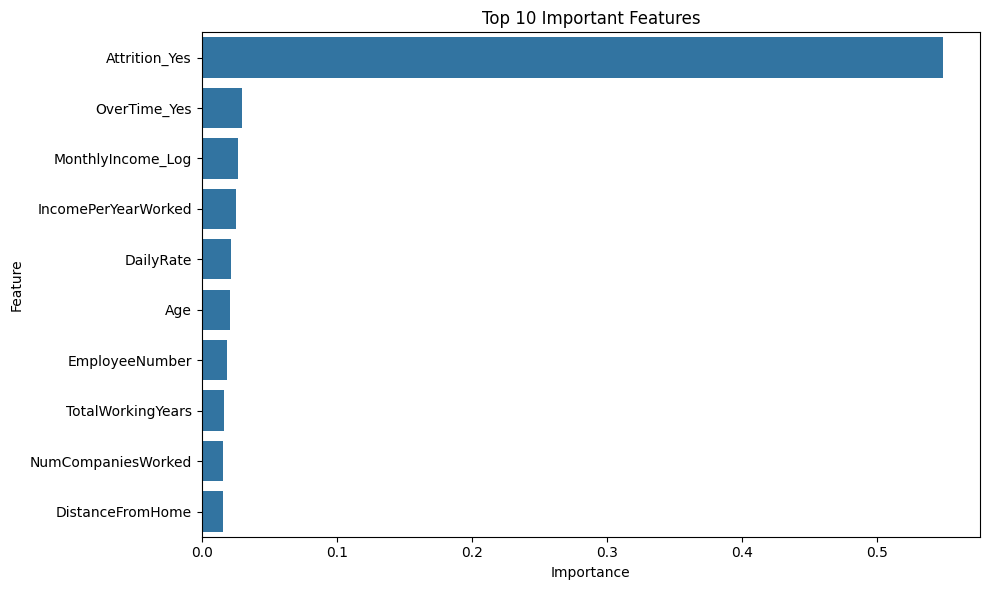

In [32]:
# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 상위 10개 중요 특성 시각화
sns.barplot(x='importance', y='feature', data=feature_importance)

# 제목과 축 레이블 설정
plt.title('Top 10 Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')

# 그래프 표시
plt.tight_layout()
plt.show()

In [75]:
# overfitting이 발생 수정 필요
### problem: dataset 작음

## 2. 성능 비교 및 선택

### 2-1. overfitting 해결

In [33]:
# over fitting solution - 모델 복잡도 낮추기

models = {
    'Logistic Regression': LogisticRegression(max_iter=100, penalty='l2', solver='lbfgs', C=0.5),  # L2 규제 추가
    'Random Forest': RandomForestClassifier(n_estimators=20, max_depth=4, random_state=42),  # 트리 개수와 깊이를 조정하여 과적합 방지
    'XGBoost': XGBClassifier(n_estimators=10, max_depth=3, learning_rate=0.1, min_child_weight=3, reg_alpha=0.5, reg_lambda=0.5, use_label_encoder=False, random_state=42)  # 추가 규제 파라미터 설정
}

# 모델을 교차 검증 통해 평가
results = []
for model_name, model in models.items():
    print(f"Evaluating {model_name} with Cross Validation...")
    # 교차 검증 (5-Fold Cross Validation)
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    avg_score = scores.mean()
    results.append({'Model': model_name, 'Average F1 Score': avg_score})

results_df = pd.DataFrame(results)

best_model = results_df.loc[results_df['Average F1 Score'].idxmax()]
results_df, best_model

Evaluating Logistic Regression with Cross Validation...
Evaluating Random Forest with Cross Validation...
Evaluating XGBoost with Cross Validation...


/opt/miniconda3/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt

(                 Model  Average F1 Score
 0  Logistic Regression          1.000000
 1        Random Forest          0.940285
 2              XGBoost          1.000000,
 Model               Logistic Regression
 Average F1 Score                    1.0
 Name: 0, dtype: object)

In [34]:
# Feature Selection 재검토
# 데이터 불러오기
file_path = '/Users/j/Desktop/AI camp/2차 프로젝트/SKN06-2nd-7Team/Data/HR_Employee.csv'
data = pd.read_csv(file_path)
# 타겟 변수와 특성 변수 분리
target = data['Attrition']
data_features = data.drop(columns=['Attrition'])
# 범주형 변수 변환 - One-Hot Encoding
data_encoded = pd.get_dummies(data_features, drop_first=True)
# 타겟 변수 인코딩 (No -> 0, Yes -> 1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target_encoded = le.fit_transform(target)
# 수치형 변수 상관계수 기반 제거
corr_matrix = data_encoded.corr()
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
columns_to_drop = [pair[1] for pair in high_corr_pairs]  # 상관계수가 높은 변수 중 하나 제거
# 카이제곱 검정 기반 범주형 변수 제거
from scipy.stats import chi2_contingency
categorical_features = data.select_dtypes(include=['object']).columns
categorical_features = categorical_features.drop('Attrition')
chi2_insignificant_vars = []
for feature in categorical_features:
    contingency_table = pd.crosstab(data[feature], target_encoded)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p > 0.05:
        chi2_insignificant_vars.append(feature)
# 최종 제거할 변수 목록에 추가 
columns_to_drop.extend(chi2_insignificant_vars)
columns_to_drop = [col for col in columns_to_drop if col in data_encoded.columns]  # 중복 변수 확인 후 데이터프레임에 존재하는 변수만 제거
# 변수 제거
data_cleaned = data_encoded.drop(columns=columns_to_drop)
# 변수 선택 후 최종 데이터 분리
X = data_cleaned
y = target_encoded

### 2-2. 모델 및 하이퍼파라미터 그리드 정의

In [35]:
# 모델 및 하이퍼파라미터 그리드 정의
models1 = {
    'Logistic Regression': LogisticRegression(max_iter=100, penalty='l2', solver='lbfgs', C=0.5)
}

models2 = {
    'Random Forest': RandomForestClassifier(n_estimators=20, max_depth=4, random_state=42)
}

models3 = {
    'XGBoost': XGBClassifier(n_estimators=10, max_depth=3, learning_rate=0.1, min_child_weight=3, reg_alpha=0.5, reg_lambda=0.5, use_label_encoder=False, random_state=42)
}


### 2-2. 각 모델 그리드 서치 수행


In [36]:
# 각 모델 그리드 서치 수행
results1 = []
results2 = []
results3 = []

for model_name, model in models1.items():
    print(f"Evaluating {model_name} with Cross Validation...")
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    avg_score = scores.mean()
    results1.append({'Model': model_name, 'Average F1 Score': avg_score})\
    
for model_name, model in models2.items():
    print(f"Evaluating {model_name} with Cross Validation...")
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    avg_score = scores.mean()
    results2.append({'Model': model_name, 'Average F1 Score': avg_score})

for model_name, model in models3.items():
    print(f"Evaluating {model_name} with Cross Validation...")
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    avg_score = scores.mean()
    results3.append({'Model': model_name, 'Average F1 Score': avg_score})

results_df1 = pd.DataFrame(results1)
results_df2 = pd.DataFrame(results2)
results_df3 = pd.DataFrame(results3)

print(results_df1)
print(results_df2)
print(results_df3)

Evaluating Logistic Regression with Cross Validation...
Evaluating Random Forest with Cross Validation...


/opt/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Evaluating XGBoost with Cross Validation...


/opt/miniconda3/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 Model  Average F1 Score
0  Logistic Regression          0.776981
           Model  Average F1 Score
0  Random Forest          0.784453
     Model  Average F1 Score
0  XGBoost           0.78681


/opt/miniconda3/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### 2-3. 결과 비교


In [48]:
# 재학습
models3["XGBoost"].fit(X_train, y_train)

/opt/miniconda3/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:42:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [51]:
## 특성 중요도 확인
feature_importance2 = pd.DataFrame({'feature': X_train.columns, 'importance': models3['XGBoost'].feature_importances_})
feature_importance2 = feature_importance.sort_values('importance', ascending=False).head(10)
print("\nTop 10 Important Features:")
print(feature_importance2)


Top 10 Important Features:
                feature  importance
29        Attrition_Yes    0.548834
50         OverTime_Yes    0.030049
25    MonthlyIncome_Log    0.026783
28  IncomePerYearWorked    0.025787
1             DailyRate    0.021722
0                   Age    0.021101
5        EmployeeNumber    0.018506
18    TotalWorkingYears    0.016219
12   NumCompaniesWorked    0.016004
2      DistanceFromHome    0.015722


In [25]:
# 결과 비교
print("Model Comparison:")
for model_name, avg_score in results1.items():
    print(f"{modle_name}: Average F1 Score: {result1[avg_score]:.f}")
for model_name, avg_score in results2.items():
    print(f"{model_name}: Average F1 Score: {result2[avg_score]:.f}")
for model_name, avg_score in results3.items():
    print(f"{model_name}: Average F1 Score: {result3[avg_score]:.f}")

Model Comparison:


NameError: name 'results1' is not defined

## 3. 모델 저장, 최종 테스트

In [108]:
best_xgb = models3

In [ ]:
##### 모델 저장
joblib.dump(best_xgb, '/Users/j/Desktop/AI camp/2차 프로젝트/SKN06-2nd-7Team/Model/best_xgb.pkl')

print("Models saved successfully.")

Models saved successfully.
